In [2]:
cd ..

/home/yann/IVISpaces


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

import math

from torchvision import datasets, transforms
from torchvision.utils import make_grid


from Metrics import evaluate_metrics
from Experiments import get_setup


In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [45]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.to(device)

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [60]:

def log_gaussian_loss(output, target, sigma, no_dim=1):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma*torch.tensor(2*math.pi).sqrt())
    
    return -(log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [61]:
class MC_Dropout_Layer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(MC_Dropout_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        dropout_mask = torch.bernoulli((1 - self.dropout_prob)*torch.ones(self.weights.shape)).to(device)
        
        return torch.mm(x, self.weights*dropout_mask) + self.biases

In [62]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.drop_prob=drop_prob
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.layer1 = nn.Linear(input_dim, no_units)
        self.layer2 = nn.Linear(no_units, output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.FloatTensor([init_log_noise]).to(device))

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

In [63]:
class MC_Dropout_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, weight_decay, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = MC_Dropout_Model(input_dim = input_dim, output_dim = output_dim,
                                        no_units = no_units, init_log_noise = init_log_noise, drop_prob = drop_prob)
        self.network.to(device)
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output, y, torch.exp(self.network.log_noise), 1)/len(x)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output)
        
        means = torch.cat(means, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + torch.exp(self.network.log_noise)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

In [50]:
def toy_test(x_train,x_test,y_train,number_point):
    np.random.seed(2)
    no_points = number_point
    lengthscale = 1
    variance = 1.0 
    sig_noise = 0.3
    x = torch.cat((x_train,x_test),0).cpu().numpy()
    x.sort(axis = 0)
    
    num_epochs, batch_size = 2000, len(x_train)
    
    net = MC_Dropout_Wrapper(input_dim = 1, output_dim=1, no_units=200, learn_rate=1e-2,
                         batch_size=batch_size, no_batches=1, init_log_noise=0, weight_decay=1e-2)
    fit_loss_train = np.zeros(num_epochs)
    best_net, best_loss = None, float('inf')
    nets, losses = [], []
    for i in range(num_epochs):
        loss = net.fit(x_train, y_train)
        losses.append(loss)

        if i % 200 == 0:
            print('Epoch: %4d, Train loss = %7.3f' % (i, loss.cpu().data.numpy()/batch_size))

    return net, losses



In [51]:
def show_graph():
    samples = []
    noises = []
    for i in range(1000):
        preds = net.network.forward(torch.linspace(-2, 2, 200).to(device)).cpu().data.numpy()
        samples.append(preds)
    
    samples = np.array(samples)
    means = (samples.mean(axis = 0)).reshape(-1)

    aleatoric = torch.exp(net.network.log_noise).cpu().data.numpy()
    epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
    total_unc = (aleatoric**2 + epistemic**2)**0.5


    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    plt.figure(figsize = (6, 5))
    plt.style.use('default')
    plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    plt.fill_between(np.linspace(-2, 2, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    plt.fill_between(np.linspace(-2, 2, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    plt.fill_between(np.linspace(-2, 2, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
    plt.plot(np.linspace(-2, 2, 200), means, color = 'black', linewidth = 1)
    plt.xlim([-2, 2])
    plt.ylim([-5, 7])
    plt.xlabel('$x$', fontsize=30)
    plt.title('MC dropout', fontsize=40)
    plt.tick_params(labelsize=10)
    plt.xticks(np.arange(-2, 2.1, 1))
    plt.yticks(np.arange(-4, 7, 2))
    plt.gca().set_yticklabels([])
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    plt.savefig('mc_dropout_hetero.pdf', bbox_inches = 'tight')

    #files.download("mc_dropout_hetero.pdf")

    plt.show()

# UCI Dataset #

In [64]:
def train_mc_dropout(x_train,y_train,x_test,y_test, y_stds, drop_prob, num_epochs, num_units, learn_rate, weight_decay, log_every, num_samples):
    in_dim = x_train.shape[1]
    out_dim = y_train.shape[1]
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    
    net = MC_Dropout_Wrapper(input_dim=in_dim, output_dim=out_dim, no_units=num_units,learn_rate=learn_rate, batch_size=batch_size, no_batches=1, init_log_noise=0, weight_decay=weight_decay)


    losses = []
    fit_loss_train = np.zeros(num_epochs)

    for i in range(num_epochs):
        loss = net.fit(x_train, y_train)
        losses.append(loss)
                
        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                    (i, loss.cpu().data.numpy()/len(x_train), test_loss/len(x_test), rmse*y_stds[0].cpu().data.numpy()))


    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
    y_stds=y_stds.cpu()    
    train_logliks.append((train_loss.cpu().data.numpy()/len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy()/len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
    test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())
        


    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    return net , losses

# Setup Toy#

In [53]:
drop_prob=0.05


#toy datasets : ['foong','foong_sparse', 'foong_mixed','foong2d']

dataset='foong' 

setup_ = get_setup(dataset) #get a module
setup=setup_.Setup(device) #get an object

x_train, y_train=setup.train_data() #scaled_data
x_test, y_test=setup.test_data()
input_dim=x_train.shape[1]
output_dim=y_train.shape[1]
print('input dim: {}'.format(input_dim))
print('output dim: {}'.format(output_dim))
print('nb of train samples: {}'.format(len(x_train)))

#scalar used to scale the train target to have std=1
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    print('scaler target: {}'.format(setup._scaler_y.scale_.item()))
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

input dim: 1
output dim: 1
nb of train samples: 120


In [54]:
net,losses=toy_test(x_train=x_train, x_test=x_test, y_train=y_train,number_point=len(x_train)+len(x_test))

TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not float

In [55]:
show_graph()

RuntimeError: shape '[-1, 13]' is invalid for input of size 200

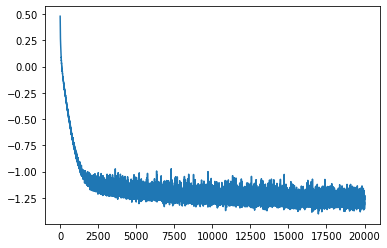

In [56]:
plt.plot(torch.arange(0,len(losses),1),torch.as_tensor(losses))

# Setup(UCI) #


In [65]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht', 'protein', 'navalC'] 
dataset='boston' 

setup_ = get_setup(dataset) #get a module
setup=setup_.Setup(device) #get an object

x_train, y_train=setup.train_data() #scaled_data
x_test, y_test=setup.test_data()
input_dim=x_train.shape[1]
output_dim=y_train.shape[1]
print('input dim: {}'.format(input_dim))
print('output dim: {}'.format(output_dim))
print('nb of train samples: {}'.format(len(x_train)))

#scalar used to scale the train target to have std=1
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    print('scaler target: {}'.format(setup._scaler_y.scale_.item()))
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).float()

input dim: 13
output dim: 1
nb of train samples: 455
scaler target: 9.307224685633784


In [66]:
#predictive model
layerwidth=50
activation=nn.ReLU()
drop_prob=0.05
num_epochs=20000
batch_size = len(x_train)
learn_rate=1e-3 #1e-5 for powerplant , navalC and 1e-6 for protein
weight_decay= 1e-1/(len(x_train)+len(x_test))**0.5 #5e-7    #
num_samples=50
log_every=50
print(learn_rate,weight_decay)

0.001 0.00444554224474387


In [67]:
net , losses = train_mc_dropout(x_train=x_train,y_train=y_train, x_test=x_test,y_test=y_test, y_stds=std_y_train,drop_prob=drop_prob, num_epochs=num_epochs,  num_units=layerwidth, learn_rate=learn_rate,
                       weight_decay=weight_decay, num_samples=num_samples, log_every=log_every)

Epoch:    0, Train loss:  0.003 Test loss:  1.248 RMSE: 7.553
Epoch:   50, Train loss:  0.002 Test loss:  0.988 RMSE: 4.415
Epoch:  100, Train loss:  0.002 Test loss:  0.880 RMSE: 3.350
Epoch:  150, Train loss:  0.002 Test loss:  0.808 RMSE: 2.952
Epoch:  200, Train loss:  0.002 Test loss:  0.751 RMSE: 2.816
Epoch:  250, Train loss:  0.002 Test loss:  0.701 RMSE: 2.780
Epoch:  300, Train loss:  0.001 Test loss:  0.645 RMSE: 2.596
Epoch:  350, Train loss:  0.001 Test loss:  0.596 RMSE: 2.534
Epoch:  400, Train loss:  0.001 Test loss:  0.552 RMSE: 2.518
Epoch:  450, Train loss:  0.001 Test loss:  0.512 RMSE: 2.529
Epoch:  500, Train loss:  0.001 Test loss:  0.468 RMSE: 2.484
Epoch:  550, Train loss:  0.001 Test loss:  0.433 RMSE: 2.518
Epoch:  600, Train loss:  0.001 Test loss:  0.403 RMSE: 2.577
Epoch:  650, Train loss:  0.001 Test loss:  0.369 RMSE: 2.559
Epoch:  700, Train loss:  0.001 Test loss:  0.340 RMSE: 2.583
Epoch:  750, Train loss:  0.001 Test loss:  0.311 RMSE: 2.581
Epoch:  

Epoch: 6700, Train loss: -0.001 Test loss: -0.008 RMSE: 2.297
Epoch: 6750, Train loss: -0.001 Test loss:  0.004 RMSE: 2.247
Epoch: 6800, Train loss: -0.001 Test loss: -0.042 RMSE: 2.240
Epoch: 6850, Train loss: -0.001 Test loss:  0.016 RMSE: 2.288
Epoch: 6900, Train loss: -0.001 Test loss:  0.035 RMSE: 2.278
Epoch: 6950, Train loss: -0.001 Test loss: -0.021 RMSE: 2.222
Epoch: 7000, Train loss: -0.001 Test loss: -0.062 RMSE: 2.230
Epoch: 7050, Train loss: -0.001 Test loss:  0.009 RMSE: 2.262
Epoch: 7100, Train loss: -0.001 Test loss: -0.043 RMSE: 2.196
Epoch: 7150, Train loss: -0.001 Test loss: -0.036 RMSE: 2.243
Epoch: 7200, Train loss: -0.001 Test loss: -0.016 RMSE: 2.221
Epoch: 7250, Train loss: -0.001 Test loss: -0.011 RMSE: 2.275
Epoch: 7300, Train loss: -0.001 Test loss: -0.009 RMSE: 2.246
Epoch: 7350, Train loss: -0.000 Test loss: -0.023 RMSE: 2.228
Epoch: 7400, Train loss: -0.001 Test loss: -0.060 RMSE: 2.209
Epoch: 7450, Train loss: -0.001 Test loss: -0.060 RMSE: 2.247
Epoch: 7

Epoch: 13300, Train loss: -0.001 Test loss: -0.012 RMSE: 2.235
Epoch: 13350, Train loss: -0.001 Test loss:  0.008 RMSE: 2.267
Epoch: 13400, Train loss: -0.001 Test loss: -0.063 RMSE: 2.235
Epoch: 13450, Train loss: -0.001 Test loss: -0.033 RMSE: 2.211
Epoch: 13500, Train loss: -0.001 Test loss: -0.054 RMSE: 2.245
Epoch: 13550, Train loss: -0.001 Test loss: -0.068 RMSE: 2.215
Epoch: 13600, Train loss: -0.001 Test loss:  0.002 RMSE: 2.204
Epoch: 13650, Train loss: -0.001 Test loss:  0.010 RMSE: 2.297
Epoch: 13700, Train loss: -0.001 Test loss:  0.002 RMSE: 2.255
Epoch: 13750, Train loss: -0.001 Test loss: -0.007 RMSE: 2.216
Epoch: 13800, Train loss: -0.001 Test loss: -0.031 RMSE: 2.210
Epoch: 13850, Train loss: -0.001 Test loss: -0.021 RMSE: 2.217
Epoch: 13900, Train loss: -0.001 Test loss: -0.043 RMSE: 2.223
Epoch: 13950, Train loss: -0.001 Test loss: -0.004 RMSE: 2.237
Epoch: 14000, Train loss: -0.001 Test loss: -0.035 RMSE: 2.202
Epoch: 14050, Train loss: -0.001 Test loss:  0.003 RMSE

Epoch: 19900, Train loss: -0.001 Test loss: -0.036 RMSE: 2.201
Epoch: 19950, Train loss: -0.001 Test loss: -0.041 RMSE: 2.221
Epoch: 19999, Train loss: -0.001 Test loss: -0.048 RMSE: 2.216
Train log. lik. = -1.741 +/-  0.000
Test  log. lik. = -2.156 +/-  0.000
Train RMSE      =  1.221 +/-  0.000
Test  RMSE      =  2.167 +/-  0.000


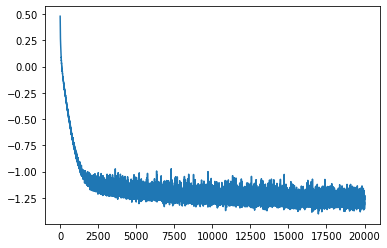

In [18]:
plt.plot(torch.arange(0,len(losses),1),torch.as_tensor(losses))

# Results on test #

In [68]:
nb_predictors=num_samples
samples = []
noises = []
for i in range(nb_predictors):
    preds = net.network.forward(x_test).cpu().data.numpy()
    samples.append(preds)
    
samples = np.array(samples)

means = torch.Tensor(samples.mean(axis = 0)).view(1,-1,1)

aleatoric = torch.exp(net.network.log_noise).detach()
epistemic = torch.Tensor(samples.var(axis = 0)**0.5).view(-1,1)



y_pred = means + epistemic * torch.randn(1000,len(x_test),1) 


sigma_noise = aleatoric.view(1,-1,1)

evaluate_metrics(y_pred,sigma_noise.cpu(), y_test, std_y_train.squeeze(), device='cpu', std=True)

{'RMSE': (2.231454610824585, 3.288661479949951),
 'LPP': (-2.170377016067505, 1.2381031513214111),
 'gLPP': (-2.296548843383789, nan),
 'WAIC': -3.448030114173889,
 'PICP': 0.9411764740943909,
 'MPIW': 7.059555530548096}

In [69]:
from Tools import log_norm
print(y_test.shape,y_pred.shape, sigma_noise.shape)
def LPP_Gaussian(y_pred_, y_test_, sigma_noise, y_scale):
    y_sigma=torch.sqrt(y_pred_.var(0)+sigma_noise**2)
    y_mean=y_pred_.mean(0)
    LPP = log_norm(y_test_.unsqueeze(1), y_mean.unsqueeze(0), y_sigma.view(1,-1,1))
    #account for data scaling
    print(LPP.shape)
    LPP-=y_scale.log() 
    MLPP = torch.mean(LPP).item()
    SLPP = torch.std(LPP).item()
    return (MLPP, SLPP)

LPP_Gaussian(y_pred, y_test.cpu(), sigma_noise.cpu(), std_y_train.squeeze().cpu())

torch.Size([51, 1]) torch.Size([1000, 51, 1]) torch.Size([1, 1, 1])
torch.Size([1, 51, 1, 1])


(-2.1706185340881348, 1.2357640266418457)

In [ ]:
Evaluation of 1D normal distribution on tensors

    Parameters:
        x (Tensor): Data tensor of size S x N x 1 
        mu (Tensor): Mean tensor of size B x S x 1
        std (Float): Tensor of size B x S x 1(standard deviation)

    Returns:
        logproba (Tensor): size B x S x N x 1 with logproba[b,s,n]=[log p(x(s,n)|mu(b,s),std[b])]
    """